### 1. Data Preprocessing


[Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) - place csv file in /src/data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('./data/creditcard.csv')

In [2]:
dataset.keys()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [3]:
dataset['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split


# stratified split
positive_cases = dataset[dataset['Class'] == 1]
negative_cases = dataset[dataset['Class'] == 0]

train_pos, test_pos = train_test_split(positive_cases, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(negative_cases, test_size=0.2, random_state=42)

train_pos_X, train_pos_y = train_pos.drop('Class', axis=1), train_pos['Class']
train_neg_X, train_neg_y = train_neg.drop('Class', axis=1), train_neg['Class']

test_pos_X, test_pos_y = test_pos.drop('Class', axis=1), test_pos['Class']
test_neg_X, test_neg_y = test_neg.drop('Class', axis=1), test_neg['Class']

train_X = pd.concat([train_pos_X, train_neg_X])
train_y = pd.concat([train_pos_y, train_neg_y])

test_X = pd.concat([test_pos_X, test_neg_X])
test_y = pd.concat([test_pos_y, test_neg_y])

### 2. Model Training

#### 2.1. Evaluation functions

In [5]:

import numpy as np
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn

def recall(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred)
    return tp / (tp + fn)

def precision(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred)
    if tp + fp == 0:
        return 0
    return tp / (tp + fp)

def f1score(y_true, y_pred):
    rec = recall(y_true, y_pred)
    prec = precision(y_true, y_pred)
    return 2 * (rec * prec) / (rec + prec)

In [6]:
def calculate_roc_curve(y_true, y_scores):
    thresholds = np.sort(y_scores)
    tpr = []
    fpr = []
    
    for threshold in thresholds:
        # Classify based on the threshold
        predicted_class = (y_scores >= threshold).astype(int)
        
        # Calculate true positives, false positives, true negatives, false negatives
        tp = np.sum((predicted_class == 1) & (y_true == 1))
        fp = np.sum((predicted_class == 1) & (y_true == 0))
        tn = np.sum((predicted_class == 0) & (y_true == 0))
        fn = np.sum((predicted_class == 0) & (y_true == 1))
        
        # Calculate TPR and FPR
        tpr.append(tp / (tp + fn))  # Sensitivity, True Positive Rate
        fpr.append(fp / (fp + tn))  # 1 - Specificity, False Positive Rate
    
    return np.array(fpr), np.array(tpr), thresholds

def plot_roc(y_true, y_pred):
    points_x, points_y, thresholds = roc(y_true, y_pred)
    plt.plot(points_x, points_y)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    

#### 2.2 Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

linear_regression_model = LogisticRegression(max_iter=1000)
linear_regression_model.fit(train_X, train_y)

lr_predictions = linear_regression_model.predict_proba(test_X)[:, 1]
lr_predictions_binary = (lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, lr_predictions_binary)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.60      0.70        99

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2.3 Random Forest

In [8]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
random_forest_model.fit(train_X, train_y)

rf_predictions = random_forest_model.predict_proba(test_X)[:, 1]
rf_predictions_binary = (rf_predictions >= 0.5).astype(int)

print(classification_report(test_y, rf_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.90      0.71      0.79        99

    accuracy                           1.00     56962
   macro avg       0.95      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962



#### 2.4 KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_X, train_y)

knn_predictions = knn_model.predict_proba(test_X)[:, 1]
knn_predictions_binary = (knn_predictions > 0).astype(int)

print(classification_report(test_y, knn_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.13      0.25      0.17        99

    accuracy                           1.00     56962
   macro avg       0.56      0.62      0.58     56962
weighted avg       1.00      1.00      1.00     56962



#### 2.5 XGBoost

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Ensure compatibility with newer pandas versions
if not hasattr(pd, 'Int64Index'):
	pd.Int64Index = pd.Index

xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=5)
xgb_model.fit(train_X, train_y)

xgb_predictions = xgb_model.predict_proba(test_X)[:, 1]
xgb_predictions_binary = (xgb_predictions >= 0.5).astype(int)

print(classification_report(test_y, xgb_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.78      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### 3. Model Evaluation

In [11]:
models = {"Logistic Regression": linear_regression_model,
          "Random Forest": random_forest_model, 
          "KNN": knn_model, 
          "XGBoost": xgb_model}

predictions = {"Logistic Regression": lr_predictions,
                "Random Forest": rf_predictions,
                "KNN": knn_predictions,
                "XGBoost": xgb_predictions}

model_threshold = {"Logistic Regression": 0.5,
              "Random Forest": 0.5,
              "KNN": 0.001,
              "XGBoost": 0.5}

dir_name = {"Logistic Regression": "LR",
            "Random Forest": "RF",
            "KNN": "KNN",
            "XGBoost": "XGB"}

knn_predictions

array([0.2, 0. , 0.2, ..., 0. , 0. , 0. ])

#### 3.1 ROC Curve

Logistic Regression
Random Forest
KNN
XGBoost


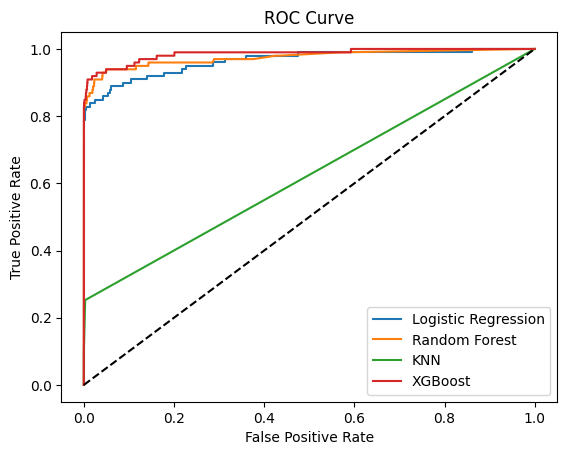

In [12]:
from sklearn.metrics import roc_curve

for name, model in models.items():
    print(name)
    fpr, tpr, thresholds = roc_curve(test_y, predictions[name])
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('./plots/roc_curve.png')
plt.show()

#### 3.2 Confusion Matrix

Logistic Regression
[[56853    10]
 [   40    59]]


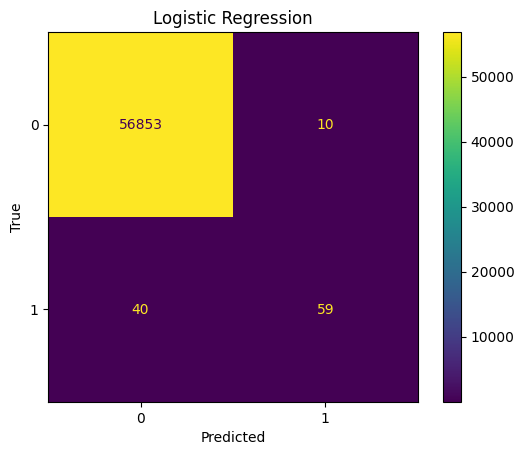

Random Forest
[[56855     8]
 [   29    70]]


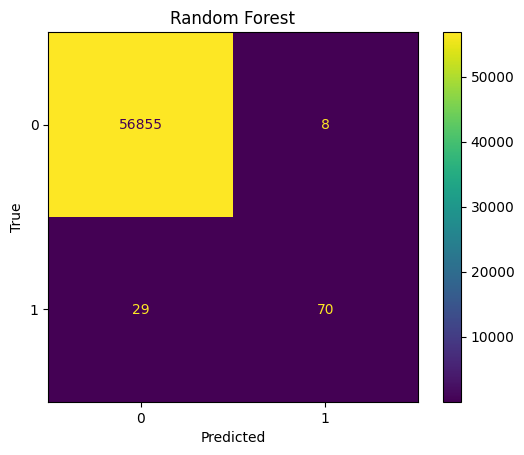

KNN
[[56690   173]
 [   74    25]]


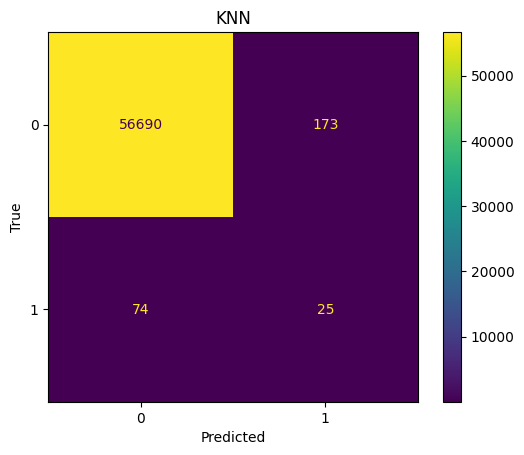

XGBoost
[[56857     6]
 [   22    77]]


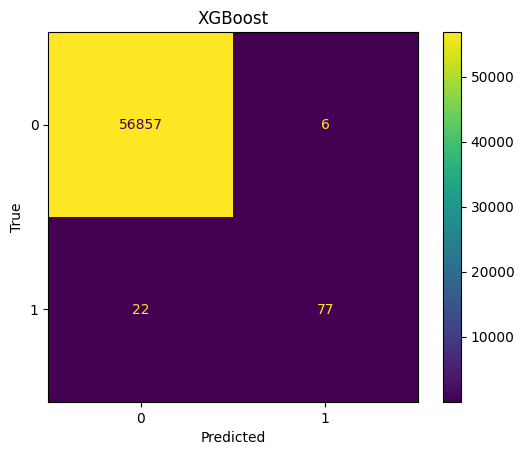

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from seaborn import heatmap

for name, model in models.items():
    print(name)
    thr = model_threshold[name]
    # thr = 0.5
    print(confusion_matrix(test_y, (predictions[name] >= thr).astype(int)))
    
    cm = confusion_matrix(test_y, (predictions[name] >= thr).astype(int))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(name)
    plt.savefig(f'./plots/{dir_name[name]}/confusion_matrix.png')
    plt.show()
    

#### 3.3 Precision-Recall Curve

Logistic Regression
Random Forest
KNN
XGBoost


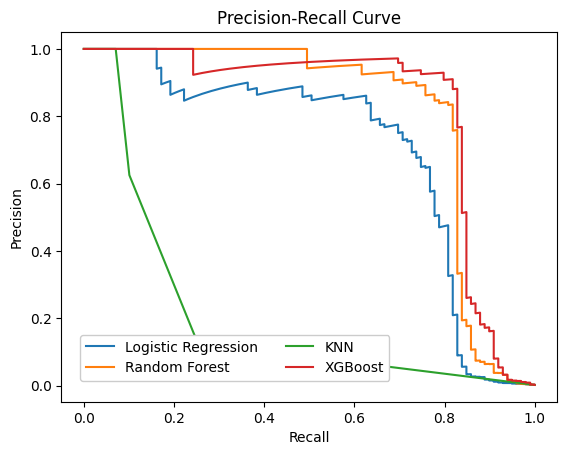

In [14]:
from sklearn.metrics import precision_recall_curve

for name, model in models.items():
    print(name)
    precision, recall, thresholds = precision_recall_curve(test_y, predictions[name])
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.35, +0.2), ncol=2, framealpha=1)
plt.savefig('./plots/precision_recall_curve.png')
plt.show()

#### 3.4 Precision, Recall, F1 Score, Accuracy Table

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize a dictionary to store the metrics
metrics = {"Model": [], "Precision": [], "Recall": [], "F1 Score": [], "Accuracy": []}

# Calculate metrics for each model
for name, model in models.items():
    thr = model_threshold[name]
    y_pred_binary = (predictions[name] >= thr).astype(int)
    precision = precision_score(test_y, y_pred_binary)
    recall = recall_score(test_y, y_pred_binary)
    f1 = f1_score(test_y, y_pred_binary)
    accuracy = accuracy_score(test_y, y_pred_binary)
    
    metrics["Model"].append(name)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1 Score"].append(f1)
    metrics["Accuracy"].append(accuracy)

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                 Model  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression   0.855072  0.595960  0.702381  0.999122
1        Random Forest   0.897436  0.707071  0.790960  0.999350
2                  KNN   0.126263  0.252525  0.168350  0.995664
3              XGBoost   0.927711  0.777778  0.846154  0.999508


In [16]:
print(positive_cases.shape, negative_cases.shape)

(492, 31) (284315, 31)


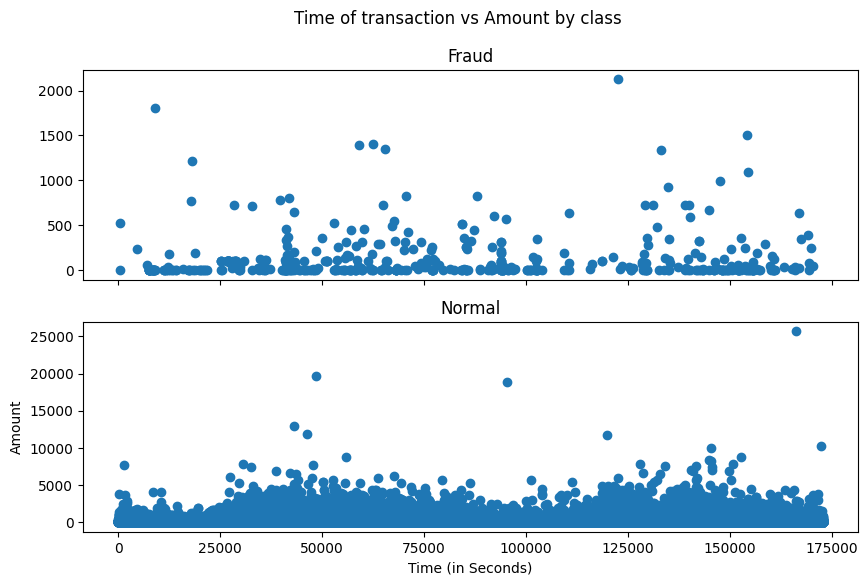

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(positive_cases['Time'], positive_cases['Amount'])
ax1.set_title('Fraud')
ax2.scatter(negative_cases['Time'], negative_cases['Amount'])
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

#### 3.5 Prediction time

In [18]:
import time

print(len(test_X))
for name, model in models.items():
    # print(name)
    start_time = time.time()
    model.predict_proba(test_X)
    end_time = time.time()

    print(f"Prediction time for {name}: {end_time - start_time} seconds")

56962
Prediction time for Logistic Regression: 0.005529642105102539 seconds
Prediction time for Random Forest: 0.0948789119720459 seconds
Prediction time for KNN: 14.101027965545654 seconds
Prediction time for XGBoost: 0.028904199600219727 seconds


### 4. Model Improvement

#### 4.1 Logistic Regression

In [19]:
im_linear_regression_model = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear', n_jobs=-1)
im_linear_regression_model.fit(train_X, train_y)

im_lr_predictions = im_linear_regression_model.predict_proba(test_X)[:, 1]
im_lr_predictions_binary = (im_lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, im_lr_predictions_binary)) 

c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.52      0.65        99

    accuracy                           1.00     56962
   macro avg       0.94      0.76      0.82     56962
weighted avg       1.00      1.00      1.00     56962



#### 4.2 Random Forest

In [20]:
im_random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, max_features=10, max_depth=20, n_jobs=-1)
im_random_forest_model.fit(train_X, train_y)

im_rf_predictions = im_random_forest_model.predict_proba(test_X)[:, 1]
im_rf_predictions_binary = (im_rf_predictions >= 0.5).astype(int)

print(classification_report(test_y, im_rf_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.82      0.86        99

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



#### 4.3 XGBoost

In [25]:
# Ensure compatibility with newer pandas versions
if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index

im_xgb_model = XGBClassifier(n_estimators=100, random_state=42,
                             max_depth=20, max_features=10, n_jobs=-1)
im_xgb_model.fit(train_X, train_y, eval_set=[
(test_X, test_y)], verbose=False)

im_xgb_predictions = im_xgb_model.predict_proba(test_X)[:, 1]
im_xgb_predictions_binary = (im_xgb_predictions >= 0.5).astype(int)

print(classification_report(test_y, im_xgb_predictions_binary))

c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.78      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### 5. Other method of sampling - SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd


smote = SMOTE(random_state=42)
train_X_smote, train_y_smote = smote.fit_resample(train_X, train_y)

print("Before SMOTE:")
print(train_y.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(train_y_smote).value_counts())

Before SMOTE:
Class
0    227452
1       393
Name: count, dtype: int64

After SMOTE:
Class
1    227452
0    227452
Name: count, dtype: int64


#### 5.1 Model training Logistic Regression

In [31]:
smote_linear_regression_model = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear', n_jobs=-1)
smote_linear_regression_model.fit(train_X_smote, train_y_smote)

smote_lr_predictions = smote_linear_regression_model.predict_proba(test_X)[:, 1]
smote_lr_predictions_binary = (smote_lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, smote_lr_predictions_binary)) 

c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.15      0.90      0.25        99

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962



#### 5.2 Model training Random Forest

In [32]:
smote_random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, max_features=10, max_depth=20, n_jobs=-1)
smote_random_forest_model.fit(train_X_smote, train_y_smote)

smote_rf_predictions = smote_random_forest_model.predict_proba(test_X)[:, 1]
smote_rf_predictions_binary = (smote_rf_predictions >= 0.5).astype(int)

print(classification_report(test_y, smote_rf_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.79      0.84      0.81        99

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



#### 5.3 Model training KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

smote_knn_model = KNeighborsClassifier(n_neighbors=5)
smote_knn_model.fit(train_X_smote, train_y_smote)

smote_knn_predictions = smote_knn_model.predict_proba(test_X)[:, 1]
smote_knn_predictions_binary = (smote_knn_predictions > 0).astype(int)

print(classification_report(test_y, smote_knn_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56863
           1       0.01      0.53      0.02        99

    accuracy                           0.88     56962
   macro avg       0.50      0.70      0.48     56962
weighted avg       1.00      0.88      0.94     56962



#### 5.4 Model training XGBoost

In [34]:
# Ensure compatibility with newer pandas versions
if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index

smote_xgb_model = XGBClassifier(n_estimators=100, random_state=42,
                             max_depth=20, max_features=10, n_jobs=-1)
smote_xgb_model.fit(train_X_smote, train_y_smote, eval_set=[
(test_X, test_y)], verbose=False)

smote_xgb_predictions = smote_xgb_model.predict_proba(test_X)[:, 1]
smote_xgb_predictions_binary = (smote_xgb_predictions >= 0.5).astype(int)

print(classification_report(test_y, smote_xgb_predictions_binary))

c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.84      0.85        99

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [36]:
models = {"Logistic Regression": smote_linear_regression_model,
          "Random Forest": smote_random_forest_model, 
          "KNN": smote_knn_model, 
          "XGBoost": smote_xgb_model}

predictions = {"Logistic Regression": smote_lr_predictions,
                "Random Forest": smote_rf_predictions,
                "KNN": smote_knn_predictions,
                "XGBoost": smote_xgb_predictions}

model_threshold = {"Logistic Regression": 0.5,
              "Random Forest": 0.5,
              "KNN": 0.001,
              "XGBoost": 0.5}

dir_name = {"Logistic Regression": "LR",
            "Random Forest": "RF",
            "KNN": "KNN",
            "XGBoost": "XGB"}

knn_predictions

array([0.2, 0. , 0.2, ..., 0. , 0. , 0. ])

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize a dictionary to store the metrics
metrics = {"Model": [], "Precision": [], "Recall": [], "F1 Score": [], "Accuracy": []}

# Calculate metrics for each model
for name, model in models.items():
    thr = model_threshold[name]
    y_pred_binary = (predictions[name] >= thr).astype(int)
    precision = precision_score(test_y, y_pred_binary)
    recall = recall_score(test_y, y_pred_binary)
    f1 = f1_score(test_y, y_pred_binary)
    accuracy = accuracy_score(test_y, y_pred_binary)
    
    metrics["Model"].append(name)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1 Score"].append(f1)
    metrics["Accuracy"].append(accuracy)

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                 Model  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression   0.147107  0.898990  0.252841  0.990766
1        Random Forest   0.790476  0.838384  0.813725  0.999333
2                  KNN   0.007808  0.525253  0.015387  0.883168
3              XGBoost   0.855670  0.838384  0.846939  0.999473
